In [30]:
import pandas as pd 
import numpy as np 
from __future__ import division
from __future__ import print_function

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
print(sys.path)
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import combo
from pyod.models.knn import KNN
#from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

['c:\\Users\\navya\\Desktop\\AnomalyDetection\\Code\\Scripts', 'C:\\Users\\navya\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip', 'C:\\Users\\navya\\AppData\\Local\\Programs\\Python\\Python311\\DLLs', 'C:\\Users\\navya\\AppData\\Local\\Programs\\Python\\Python311\\Lib', 'C:\\Users\\navya\\AppData\\Local\\Programs\\Python\\Python311', 'c:\\Users\\navya\\Desktop\\AnomalyDetection\\Code', '', 'c:\\Users\\navya\\Desktop\\AnomalyDetection\\Code\\Lib\\site-packages', 'c:\\Users\\navya\\Desktop\\AnomalyDetection\\Code\\Lib\\site-packages\\win32', 'c:\\Users\\navya\\Desktop\\AnomalyDetection\\Code\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\navya\\Desktop\\AnomalyDetection\\Code\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\navya\\Desktop\\AnomalyDetection\\Code', 'c:\\Users\\navya\\Desktop\\AnomalyDetection\\Code']


In [31]:
data=pd.read_csv('C:/Users/navya/Desktop/AnomalyDetection/dataset/PS_20174392719_1491204439457_log.csv')

In [32]:
print(data.shape)

(6362620, 11)


In [33]:
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [34]:
data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [35]:
import pandas as pd
def describe_more(df,normalize_ind=False, weight_column=None, skip_columns=[], dropna=True):
    var = [] ; l = [] ; t = []; unq =[]; min_l = []; max_l = [];
    assert isinstance(skip_columns, list), "Argument skip_columns should be list"
    if weight_column is not None:
        if weight_column not in list(df.columns):
            raise AssertionError('weight_column is not a valid column name in the input DataFrame')
      
    for x in df:
        if x in skip_columns:
            pass
        else:
            var.append( x )
            uniq_counts = len(pd.Series(df[x]).value_counts( dropna=dropna)[pd.Series(df[x]).value_counts(dropna=dropna)>0])
            l.append(uniq_counts)
            t.append( df[ x ].dtypes )
            min_l.append(df[x].apply(str).str.len().min())
            max_l.append(df[x].apply(str).str.len().max())
            df_cat_d = df[x].value_counts(normalize=normalize_ind,dropna=dropna).round(decimals=2)
            df_cat_d = df_cat_d[df_cat_d>0]
            unq.append(df_cat_d.iloc[0:200].to_dict())
            
    levels = pd.DataFrame( { 'A_Variable' : var , 'Levels' : l , 'Datatype' : t ,
                             'Min Length' : min_l,
                             'Max Length': max_l,
                             'Level_Values' : unq} )
    #levels.sort_values( by = 'Levels' , inplace = True )
    return levels

In [36]:
describe_more(data)

,A_Variable,Levels,Datatype,Min Length,Max Length,Level_Values
0,step,743,int64,1,3,"{19: 51352, 18: 49579, 187: 49083, 235: 47491,..."
1,type,5,object,5,8,"{'CASH_OUT': 2237500, 'PAYMENT': 2151495, 'CAS..."
2,amount,5316900,float64,3,11,"{10000000.0: 3207, 10000.0: 88, 5000.0: 79, 15..."
3,nameOrig,6353307,object,5,11,"{'C1902386530': 3, 'C363736674': 3, 'C54531511..."
4,oldbalanceOrg,1845844,float64,3,11,"{0.0: 2102449, 184.0: 918, 133.0: 914, 195.0: ..."
5,newbalanceOrig,2682586,float64,3,11,"{0.0: 3609566, 5888.64: 4, 15073.44: 4, 5122.0..."
6,nameDest,2722362,object,2,11,"{'C1286084959': 113, 'C985934102': 109, 'C6655..."
7,oldbalanceDest,3614697,float64,3,12,"{0.0: 2704388, 10000000.0: 615, 20000000.0: 21..."
8,newbalanceDest,3555499,float64,3,12,"{0.0: 2439433, 10000000.0: 53, 971418.91: 32, ..."
9,isFraud,2,int64,1,1,"{0: 6354407, 1: 8213}"


In [37]:
#let's check the distribution of fraudulent and non fraudulent transactions
pd.Series(data['isFraud']).value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

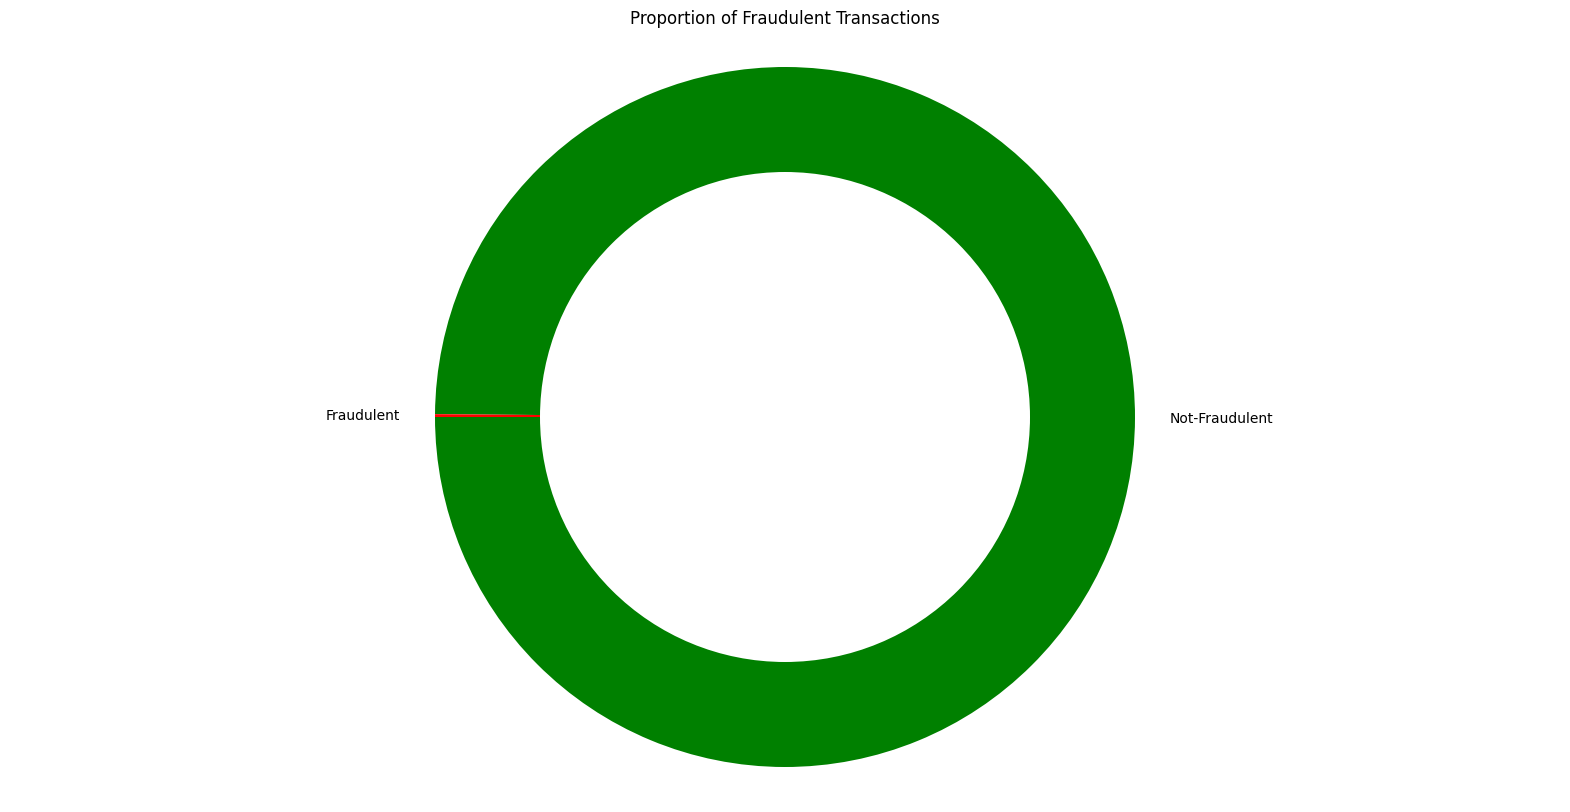

In [38]:
fraud_counts = data['isFraud'].value_counts()
plt.pie(fraud_counts,labels=['Not-Fraudulent','Fraudulent'], colors=['green', 'red'], startangle=180)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Adding title
plt.title('Proportion of Fraudulent Transactions')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Display the plot
plt.show()


In [39]:
# check the distribution of isFlaggedFraud
pd.Series(data['isFlaggedFraud']).value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

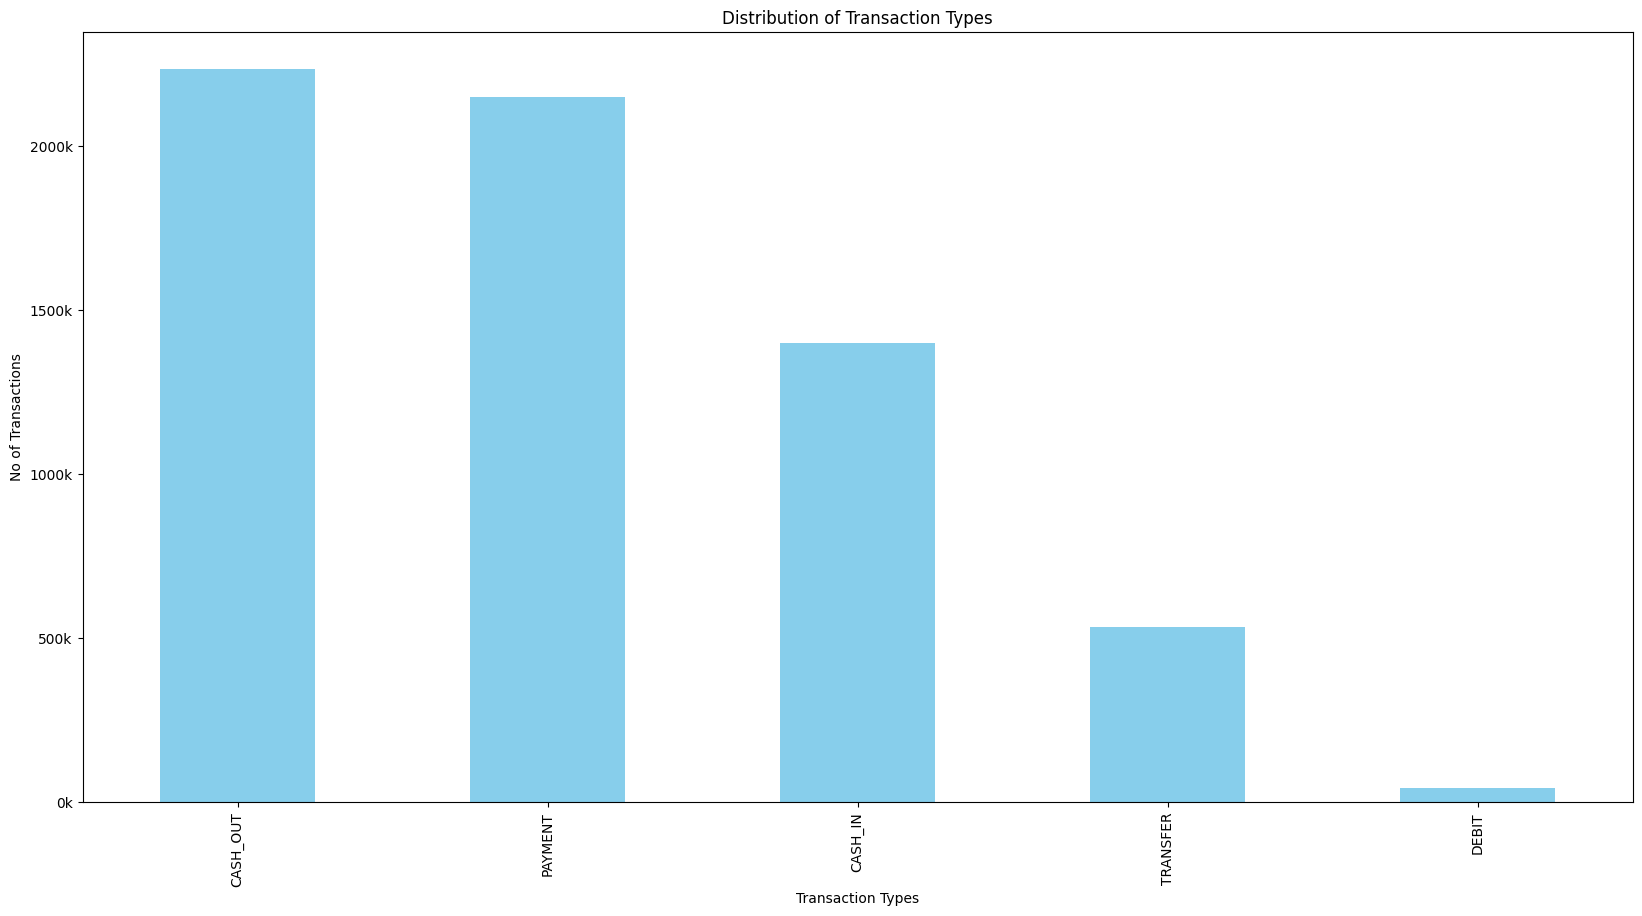

In [40]:
#Check the distribution of various types of transactions
transaction_types=['Cash-out', 'Payment', 'Cash-in', 'Transfer', 'Debit']
transaction_counts=data['type'].value_counts()
transaction_counts.plot(kind='bar',color='skyblue')
# Add labels and title
plt.xlabel('Transaction Types')
plt.ylabel('No of Transactions')
plt.title('Distribution of Transaction Types')
# Define a function to format y-axis labels
def format_func(value, tick_number):
    return f"{int(value/1000)}k"

# Set y-axis tick formatter to display values in millions with 'k' suffix
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
# Display the plot
plt.show()


In [41]:
# No of steps involved in transaction
steps_ct=data['step'].value_counts()
print("The no. of different steps involved in transactions are :", steps_ct)

The no. of different steps involved in transactions are : step
19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
432        4
706        4
693        4
112        2
662        2
Name: count, Length: 743, dtype: int64


C:\Users\navya\AppData\Local\Temp\ipykernel_23448\1039127568.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.step,fit=norm,kde=False)


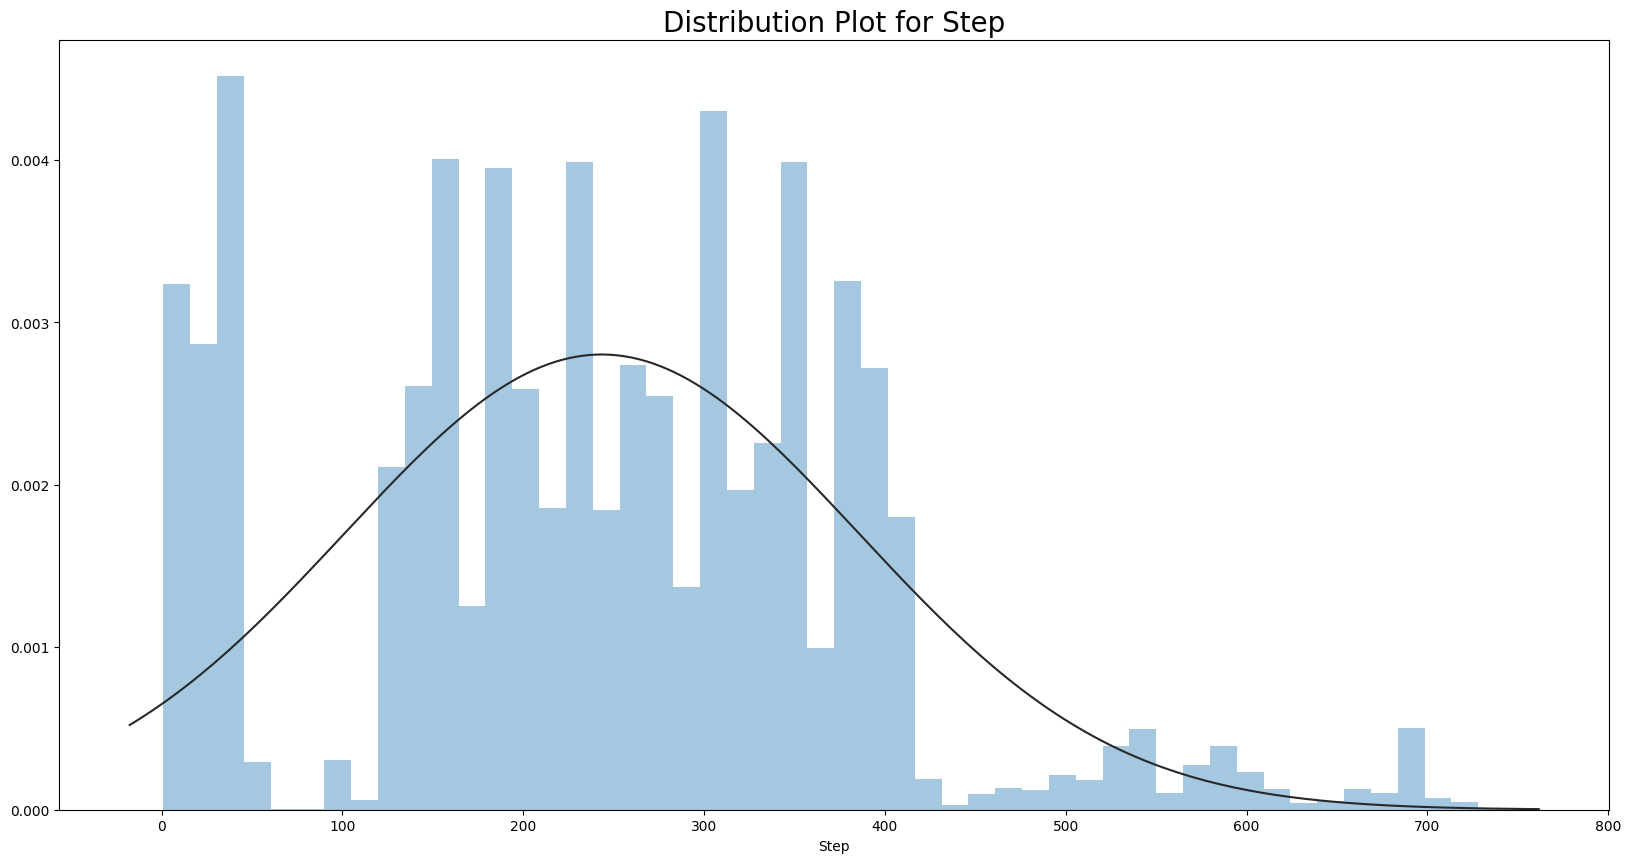

In [42]:
# Plot distribution of steps of transaction
import seaborn as sns
plt.rcParams['figure.figsize']=(20,10)
from scipy.stats import norm
sns.distplot(data.step,fit=norm,kde=False)
plt.title('Distribution Plot for Step',fontsize=20)
plt.xlabel('Step')
plt.show()

- The distribution of the number of steps in transactions exhibits a slight right skew, indicating a majority of transactions with fewer steps and a tail extending towards higher step counts. This suggests a common pattern in transaction behavior with some instances of more complex transactions.



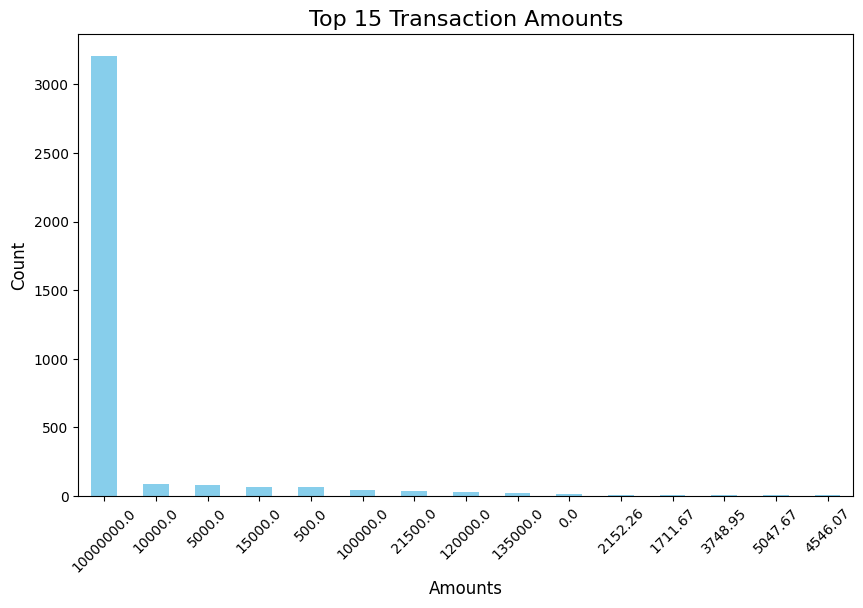

In [43]:
# Get the top 15 most common transaction amounts and their counts
top_15_amounts = data['amount'].value_counts().head(15)

# Plot the bar chart with different colors for each bar
plt.figure(figsize=(10, 6))
top_15_amounts.plot(kind='bar', color='skyblue')
plt.title('Top 15 Transaction Amounts', fontsize=16)
plt.xlabel('Amounts', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [44]:
data['amount'].value_counts()

amount
10000000.00    3207
10000.00         88
5000.00          79
15000.00         68
500.00           65
               ... 
8513.48           1
189137.90         1
1615.78           1
128891.19         1
12257.89          1
Name: count, Length: 5316900, dtype: int64

In [45]:
# # Categorical columns
# categorical_columns=[]
# for cols in data.columns:
#     if pd.api.types.is_numeric_dtype(data[cols].dtypes):
#         continue
#     else:
#         categorical_columns.append(cols)
# print(categorical_columns)    

# plt.figure(figsize=(20, 30))
# for i, column in enumerate(categorical_columns, 1):
#     plt.subplot(6, 3, i)
#     sns.countplot(data=df, x=column, palette='viridis')
#     plt.title(column, fontsize=14, fontweight='bold') 
#     plt.xlabel(None)
#     plt.ylabel(None)
#     plt.xticks(rotation=45)  

# plt.tight_layout()
# plt.show()

In [46]:
# # Bivariable check

# # Categorical
# plt.figure(figsize=(20, 30))
# for i, column in enumerate(categorical_columns, 1):
#     plt.subplot(6, 3, i)
#     sns.countplot(data=df, x=column, hue='y', palette='viridis')
#     plt.title(f'{column} vs. y')
#     plt.xlabel(None)
#     plt.ylabel(None)
#     plt.xticks(rotation=45)

# plt.tight_layout()
# plt.show()

In [47]:
# what transactions are flagged as fraudulent
print("Transactions that are fraudulent :")
print(list(data.loc[data['isFraud']==1].type.drop_duplicates()))

print("Transactions that are flagged  fraudulent :")
print(list(data.loc[data['isFlaggedFraud']==1].type.drop_duplicates()))

Transactions that are fraudulent :
['TRANSFER', 'CASH_OUT']
Transactions that are flagged  fraudulent :
['TRANSFER']


In [48]:
# count of fraud Transfers and cash outs
print('Count of fraud transfers : {}'.format(data.loc[(data['type']=='TRANSFER') & (data['isFraud']==1)].shape[0]))
print('Count of fraudulent cash outs : {}'.format(data.loc[(data['type']=='CASH_OUT') & (data['isFraud']==1)].shape[0]))


Count of fraud transfers : 4097
Count of fraudulent cash outs : 4116


In [49]:
print('count of flagged fraudulent Transfers : {}'.format(data.loc[(data['type']=='TRANSFER') & (data['isFlaggedFraud']==1)].shape[0]))

count of flagged fraudulent Transfers : 16


C:\Users\navya\AppData\Local\Temp\ipykernel_23448\334473727.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fraud_transfers, kde=False)


Text(0.5, 1.0, 'Frequency of Amounts Transferred During a Fraudulent Transaction')

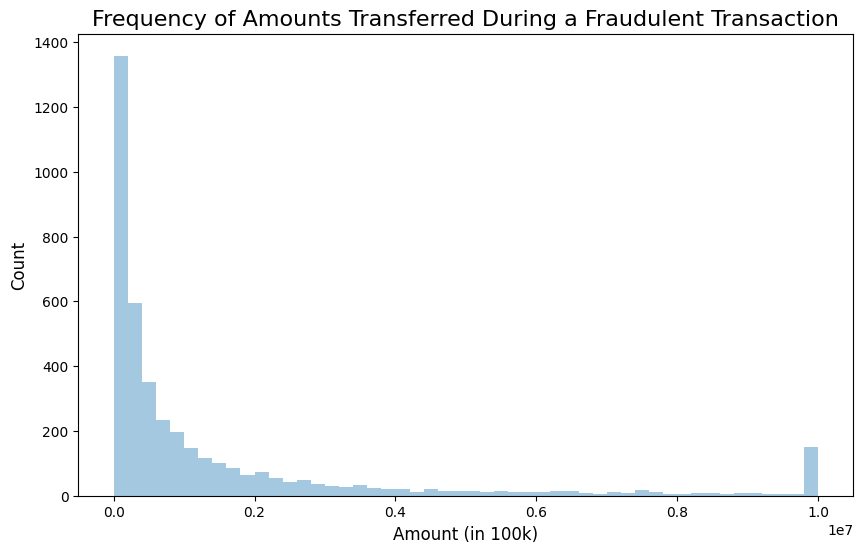

In [54]:
# plot the frequency of amounts transferred during a fraudulent transaction (scale be in 100k)

fraud_transfers = data.loc[(data['type']=='TRANSFER') & (data['isFraud']==1)]['amount']
raud_transfers = fraud_transfers/100000
plt.figure(figsize=(10, 6))
sns.distplot(fraud_transfers, kde=False)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Amount (in 100k)', fontsize=12)
plt.title('Frequency of Amounts Transferred During a Fraudulent Transaction', fontsize=16)



C:\Users\navya\AppData\Local\Temp\ipykernel_23448\2075298022.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fraud_co, kde=False , color='orange')


Text(0.5, 1.0, 'Frequency of Amounts Cashed out During a Fraudulent Transaction')

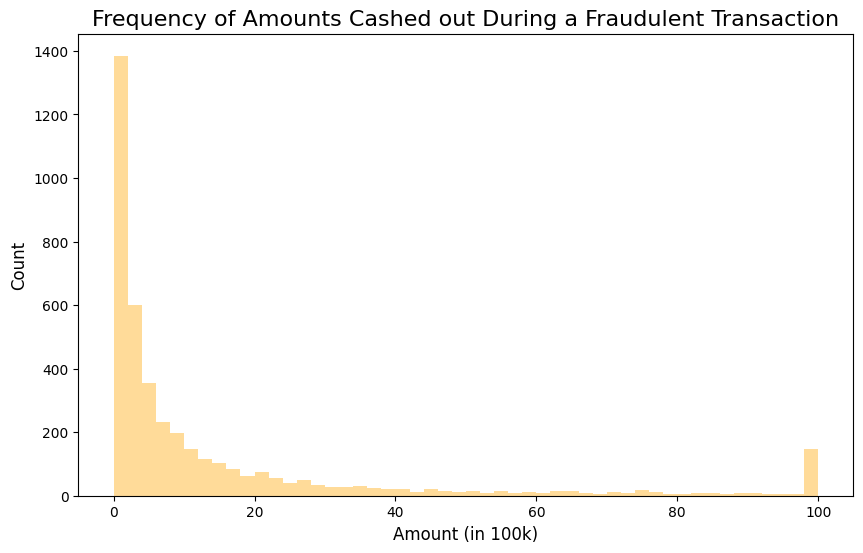

In [59]:
# plot the frequency of amounts chased out  during a fraudulent transaction (scale be in 100k) in orange color

fraud_co = data.loc[(data['type']=='CASH_OUT') & (data['isFraud']==1)]['amount']
fraud_co = fraud_co/100000
plt.figure(figsize=(10, 6))
sns.distplot(fraud_co, kde=False , color='orange')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Amount (in 100k)', fontsize=12)
plt.title('Frequency of Amounts Cashed out During a Fraudulent Transaction', fontsize=16)